In [5]:
# Imports from SCSF module
import sys
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import CONFIG1
# Standard Imports
import s3fs             # AWS-S3 connectivity for pandas
import pandas as pd
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
from cvxpy import SolverError
# Environment Setup
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime
import pp

In [2]:
def load_sys(n=None, idnum=None, base='s3://pvinsight.nrel/PVO/'):
    """
    If idnum kwarg is specified, it overwrites any user defined value in the n kwarg.
    
    :param n: The index of the sequential ordering of the systems in the metadata file
    :param idnum: The system ID number
    """

    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    if n is not None:
        idnum = meta['ID'][n]
    elif idnum is not None:
        n = meta[meta['ID'] == idnum].index[0]
    else:
        print('must provide index or ID')
        return
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(idnum), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    tz = meta['TimeZone'][n]
    df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    start = df.index[0]
    end = df.index[-1]
    time_index = pd.date_range(start=start, end=end, freq='5min')
    df = df.reindex(index=time_index, fill_value=0)
    #print(n, idnum)
    return df, idnum

In [3]:
def progress(count, total, status=''):
    """
    Python command line progress bar in less than 10 lines of code. · GitHub
    https://gist.github.com/vladignatyev/06860ec2040cb497f0f3
    :param count: the current count, int
    :param total: to total count, int
    :param status: a message to display
    :return:
    """
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [7]:
def make_avg(n):
    df, idnum = load_sys(n=i)
    days = df.resample('D').max().index[1:-1]
    start = days[0]
    end = days[-1]
    D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
    Davg = np.average(D, axis=1)
    return Davg, idnum

In [16]:
def foo(x):
    return x ** 2

In [17]:
job1 = job_server.submit(foo, (12,))

SyntaxError: EOL while scanning string literal (<string>, line 1)

In [23]:
import math, sys, time
import pp

def isprime(n):
    """Returns True if n is prime and False otherwise"""
    if not isinstance(n, int):
        raise TypeError("argument passed to is_prime is not of 'int' type")
    if n < 2:
        return False
    if n == 2:
        return True
    max = int(math.ceil(math.sqrt(n)))
    i = 2
    while i <= max:
        if n % i == 0:
            return False
        i += 1
    return True

def sum_primes(n):
    """Calculates sum of all primes below given integer n"""
    return sum([x for x in xrange(2,n) if isprime(x)])


job_server = pp.Server(ncpus=7, ppservers=())


start_time = time.time()

# The following submits 8 jobs and then retrieves the results
inputs = (100000, 100100, 100200, 100300, 100400, 100500, 100600, 100700)
jobs = [(input, job_server.submit(sum_primes,(input,), (isprime,), ("math",))) for input in inputs]
for input, job in jobs:
    print("Sum of primes below", input, "is", job())

print("Time elapsed: ", time.time() - start_time, "s")
job_server.print_stats()

SyntaxError: EOL while scanning string literal (<string>, line 1)

In [11]:
job_server = pp.Server(ncpus=7)

jobs = [
    (n, job_server.submit(
        make_avg,
        (n,),
        (load_sys,),
        ()
    ))
    for n in range(572)
]

output = []
num = len(jobs)
it = 0
progress(it, num, status='starting')
for ind, job in jobs:
    Davg, idnum = job()
    output.append(Davg)
    it += 1
    progress(it, num, status='SysID: {}           '.format(idnum))
progress(it, num, status='complete!             ')

SyntaxError: EOL while scanning string literal (<string>, line 1)

In [10]:
job_server.submit?

In [25]:
output = np.empty((288, 572))
for i in range(572):
    df, idnum = load_sys(n=i)
    days = df.resample('D').max().index[1:-1]
    start = days[0]
    end = days[-1]
    D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
    Davg = np.average(D, axis=1)
    output[:, i] = Davg
    progress(i+1, 572, ' SysID: {}'.format(idnum))

In [85]:
output_scaled = output / np.max(output, axis=0)

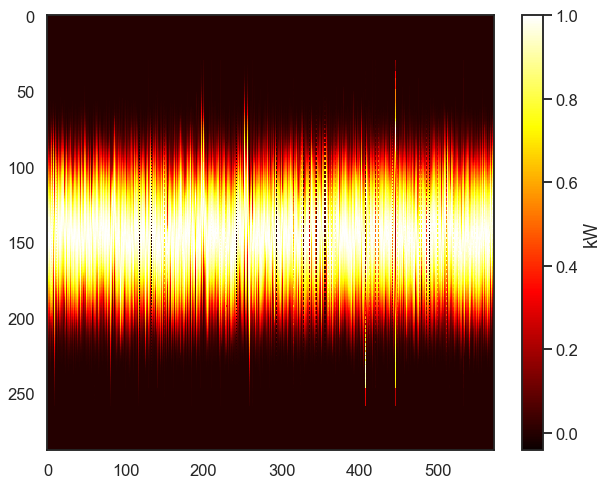

In [34]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(10,8), sharex=True)
    foo = ax.imshow(output / np.max(output, axis=0), cmap='hot', interpolation='none', aspect='auto')
    plt.colorbar(foo, ax=ax, label='kW')
plt.show()

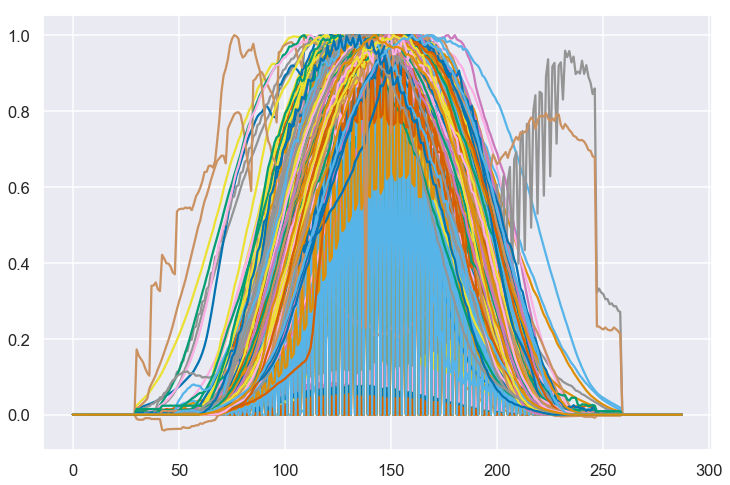

In [84]:
%matplotlib inline
plt.figure(figsize=(12, 8))
plt.plot(output / np.max(output, axis=0))
plt.show()

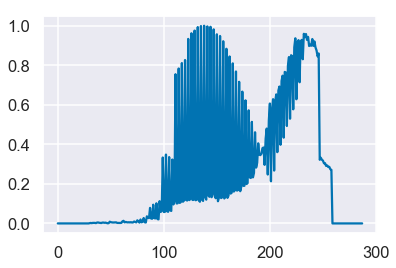

In [117]:
%matplotlib inline
plt.plot(output_scaled[:, 407])

In [94]:
v = output_scaled[:, 155]
np.sum(np.multiply(np.linspace(0, 24, 288), v)) / np.sum(v)

12.818422258802974

In [101]:
center_times = np.divide(
    np.sum(np.multiply(np.linspace(0, 24, 288), output_scaled.T), axis=1),
    np.sum(output_scaled.T, axis=1)
)

<IPython.core.display.Javascript object>


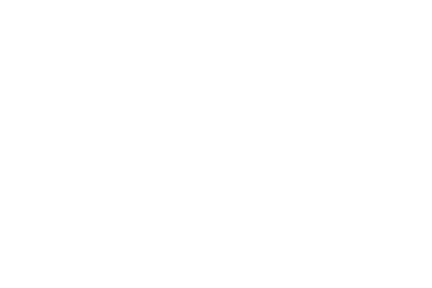

<IPython.core.display.Javascript object>


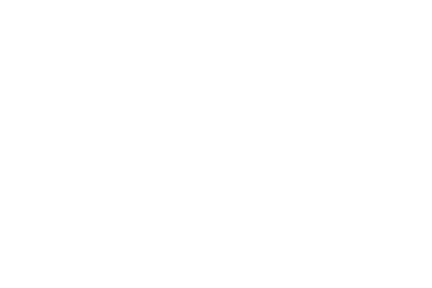

In [223]:
%matplotlib notebook
plt.plot(center_times)
plt.show()

In [127]:
centered = np.empty_like(output_scaled)
for ix, roll in enumerate(list(map(int, 144 - center_times * 12))):
    centered[:, ix] = np.roll(output_scaled[:, ix], roll)

In [175]:
center_check = np.divide(
    np.sum(np.multiply(np.linspace(0, 24, 288), centered.T), axis=1),
    np.sum(centered.T, axis=1)
)

<IPython.core.display.Javascript object>


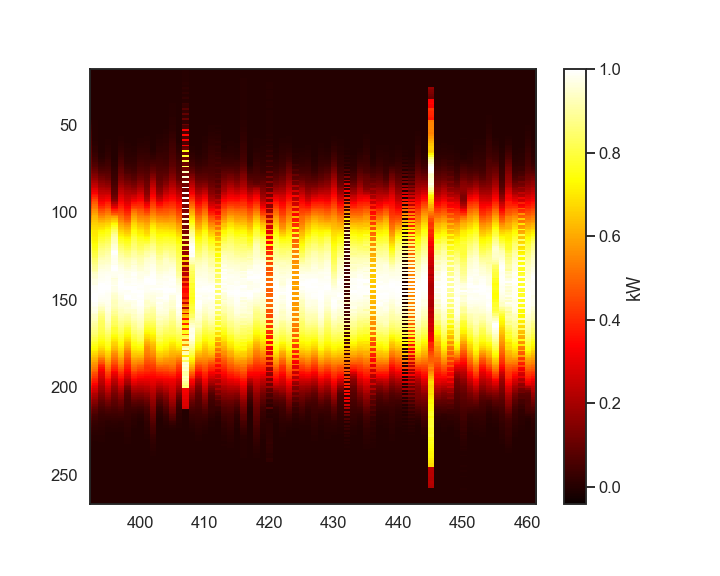

In [176]:
%matplotlib notebook
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(10,8), sharex=True)
    foo = ax.imshow(centered, cmap='hot', interpolation='none', aspect='auto')
    plt.colorbar(foo, ax=ax, label='kW')
plt.show()

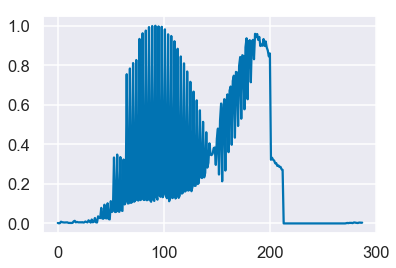

In [199]:
%matplotlib inline
v = centered[:, 407]
plt.plot(v)#[v>=1e-2])

In [200]:
from scipy.interpolate import interp1d

scaled = np.empty_like(output_scaled)
for ix in range(output_scaled.shape[1]):
    v = output_scaled[:, ix]
    vtilde = v[v > 1e-2]
    ref = np.linspace(0, 288, len(vtilde))
    f = interp1d(ref, vtilde)
    rescaled = f(np.arange(0, 288))
    scaled[:, ix] = rescaled

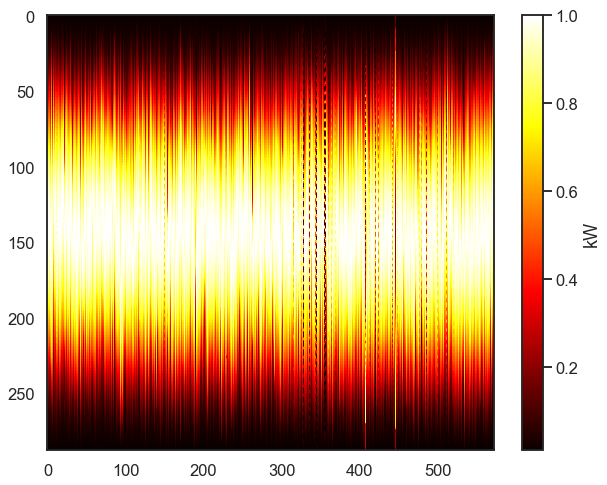

In [201]:
%matplotlib inline
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(10,8), sharex=True)
    foo = ax.imshow(scaled, cmap='hot', interpolation='none', aspect='auto')
    plt.colorbar(foo, ax=ax, label='kW')
plt.show()

In [245]:
u, d, p = np.linalg.svd(scaled)

In [318]:
from scipy.signal import morlet

def make_basis(n):
    foo = []
    for w in range(1, 3 * n, 3):
        s1 = morlet(288, w=w, s=.5)
        foo.extend([np.real(s1) / np.linalg.norm(np.real(s1)), np.imag(s1) / np.linalg.norm(np.imag(s1))])
    foo = np.array(foo)
    return foo.T

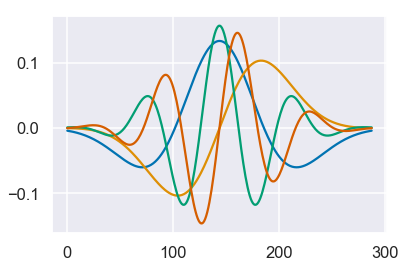

In [319]:
plt.plot(make_basis(2))
plt.show()

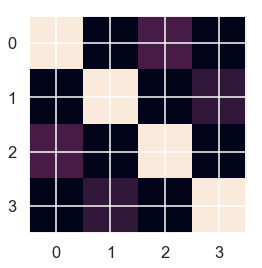

In [320]:
B = make_basis(2)
plt.imshow(B.T.dot(B))

In [325]:
projection = B.T.dot(scaled)

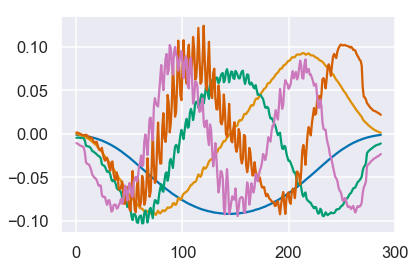

In [248]:
%matplotlib inline
plt.plot(u.T[0])
plt.plot(u.T[1])
plt.plot(u.T[2])
plt.plot(u.T[3])
plt.plot(u.T[4])

<StemContainer object of 3 artists>

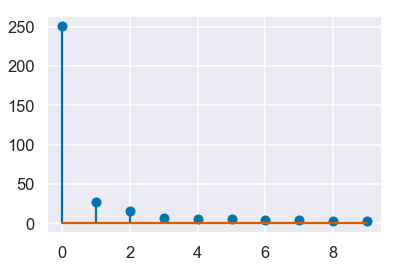

In [249]:
plt.stem(d[:10])

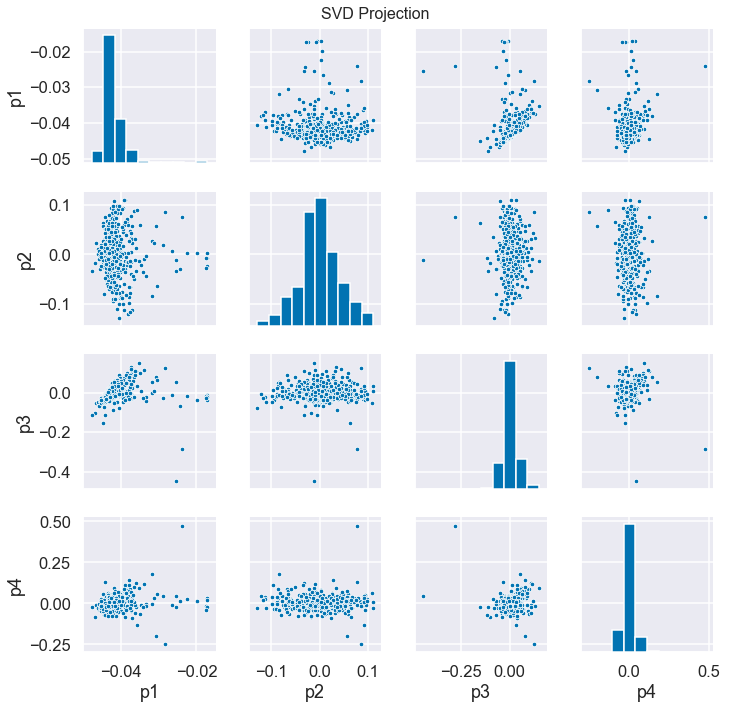

In [339]:
%matplotlib inline
df_plot = pd.DataFrame(data=p[:4].T, columns=['p{}'.format(i) for i in range(1, 5)])
sns.pairplot(df_plot, plot_kws=dict(marker='.'))
fig = plt.gcf()
fig.suptitle('SVD Projection', fontsize=16)
fig.subplots_adjust(top=.95)
plt.show()

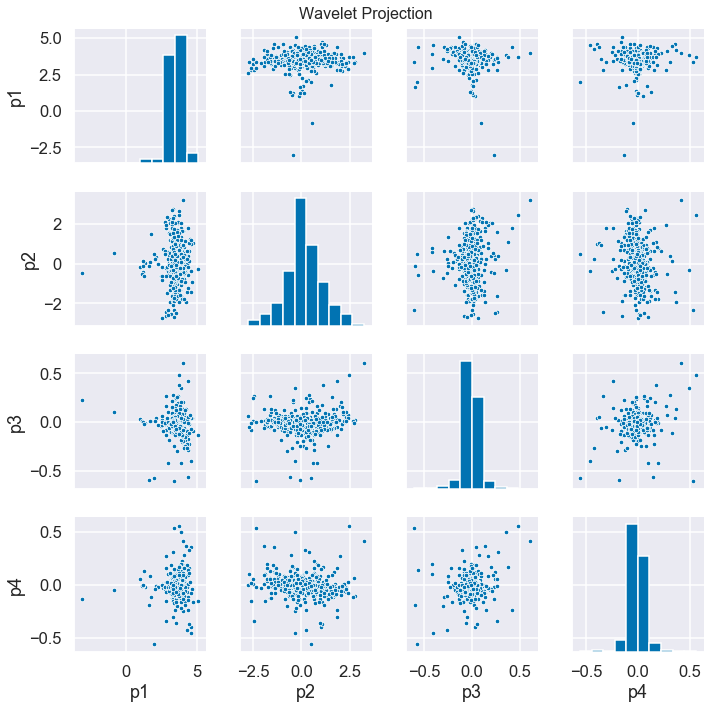

In [340]:
%matplotlib inline
df_plot = pd.DataFrame(data=projection[:4].T, columns=['p{}'.format(i) for i in range(1, 5)])
sns.pairplot(df_plot, plot_kws=dict(marker='.'))
fig = plt.gcf()
fig.suptitle('Wavelet Projection', fontsize=16)
fig.subplots_adjust(top=.95)
plt.show()

Text(0.5,0,'p2')

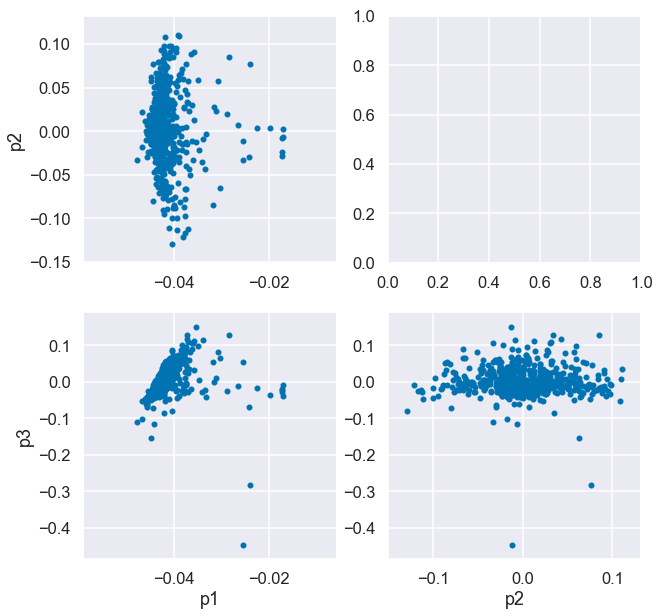

In [225]:
%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].scatter(p[0], p[1], marker='.')
ax[1, 0].scatter(p[0], p[2], marker='.')
ax[1, 1].scatter(p[1], p[2], marker='.')
ax[0, 0].set_ylabel('p2')
ax[1, 0].set_ylabel('p3')
ax[1, 0].set_xlabel('p1')
ax[1, 1].set_xlabel('p2')

<IPython.core.display.Javascript object>


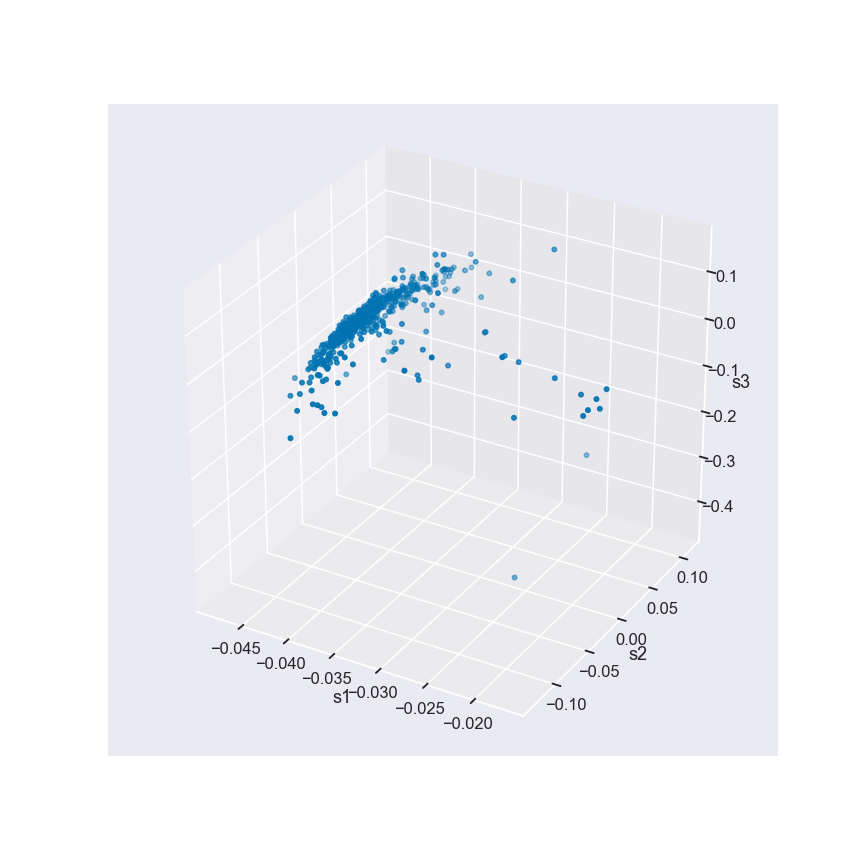

<IPython.core.display.Javascript object>


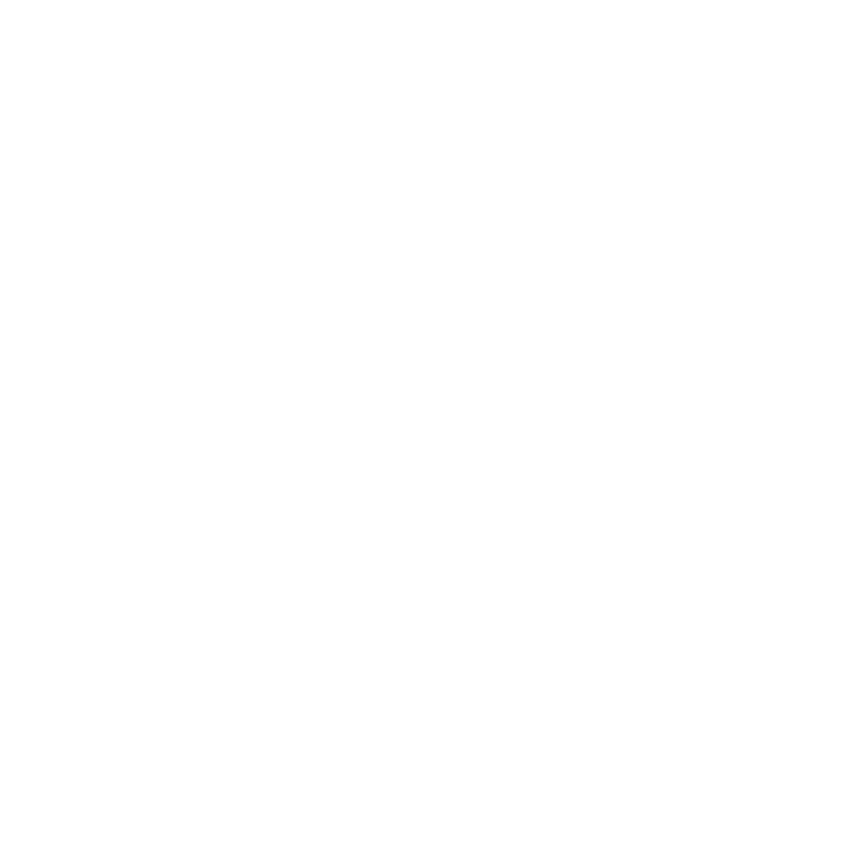

In [227]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[0], p[1], p[2], zdir='z', s=20, c=None, depthshade=True)
ax.set_xlabel('s1')
ax.set_ylabel('s2')
ax.set_zlabel('s3')
fig.canvas.draw()